In [1]:
import getpass
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.tools import PythonAstREPLTool
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser
import pandas as pd
from io import StringIO
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pandas.core.frame import DataFrame
from pandas.core.series import Series
import json
# os.environ["OPENAI_API_KEY"] = getpass.getpass('Password: ')
api_key = "sk-pzmVDXe1-rxgtV34fEob57Owp9b7Z7_k-jYKmFaguDT3BlbkFJXR835WsPGSV7P_sjJXS2QGOJBIxgW5wSzwqExklvAA"

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4", api_key=api_key)

In [2]:
class State(TypedDict):
    messages: list
    tool: PythonAstREPLTool
    file_info_list: list # (df_name, df_info, file_name)
    loop_times: int

class ChatBot:
    def __init__(self, llm):
        self.llm = llm

    def __call__(self, state: State):
        print("Enter chat")
        message = state["messages"][-1] if len(state.get("messages", [])) > 0 else ""
        if "tool" not in state:
            raise ValueError("No python code tool found in the initial state!")
        tool = state["tool"]
        llm_with_tools = self.llm.bind_tools([tool], tool_choice=tool.name)
        df_template = """```
        {df_name}.info()
        File Path of {df_name}: {file_name}
        >>> {df_info}
        ```"""
        df_context = "\n\n".join(
            df_template.format(df_name=df_name, df_info=df_info,
                            file_name=file_name)
            for df_name, df_info, file_name in state.get('file_info_list', [])
        )
        # handle adding "{}" in the system template that are not expected
        system = f"""You have access to a number of pandas dataframes. \
        Here is the info from each dataframe`:
        {df_context}
        Given a user question about the dataframes, write the Python code to answer it. \
        Return ONLY the valid Python code and nothing else. \
        Don't assume you have access to any libraries other than built-in Python ones, pandas and matplotlib. \
        Ensure that there is not index error when referring to a column name. \
        Always ENSURE that the code return a pandas Dataframe.
        Please CHECKT column name for each dataframe carefully.
        """
        # TODO: check whether need to add the original code in the prompt
        prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])
        state["messages"].append((prompt | llm_with_tools).invoke({"question": message.content})) # better with dict
        return state
    
class PythonToolNode:
    """A node that runs the python code received from the last AIMessage"""

    def __init__(self) -> None:
        pass
    
    def __call__(self, state: State):
        print("Enter Tool Node")
        if messages := state.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        tool = state["tool"]
        parser = JsonOutputKeyToolsParser(key_name=tool.name, first_tool_only=True)
        code_res = (parser | tool).invoke(message)
        # if isinstance(code_res, DataFrame) or isinstance(code_res, Series):
        #     code_res.to_csv("output_graph.csv",index=False)
        res_info = f"{code_res}"
        if "error" in res_info.lower():
            state["loop_times"] += 1
            if state["loop_times"] > 3:
                new_message = AIMessage(
                    content="Early End"
                )
                state["messages"].append(new_message)
                return state
            
            res_info = "Modify the code by the error information:\n" + f"Error: {res_info}\nCode:\n{message.tool_calls[0]['args']['query']}" 
            new_message = AIMessage(
                content=res_info
            )
        else:
            new_message = AIMessage(
                content="Ok",
            )
            print("Ok and exit the loop!")
        state["messages"].append(new_message)
        print(f"Modification {state['loop_times']}")
        return state
    
def route_tools(state: State):
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if ai_message.content == "Ok" or ai_message == "Early End":
        return END
    return "Modification"

In [3]:
graph_builder = StateGraph(State)
chatbot = ChatBot(llm=llm)
graph_builder.add_node("chatbot", chatbot)
python_node = PythonToolNode()
graph_builder.add_node("python tool", python_node)
graph_builder.add_conditional_edges(
    "python tool",
    route_tools,
    {"Modification": "chatbot", END: END},
)
graph_builder.add_edge("chatbot", "python tool")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

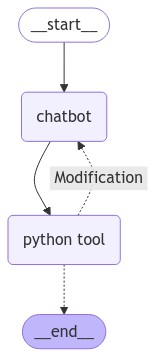

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [5]:
def create_init_state(csv_file_path_list, prompt):
    df_dict = {}
    df_info_list = []
    buffer = StringIO()
    cur = 1
    for file_path in csv_file_path_list:
        df = pd.read_csv(file_path, delimiter=',')
        file_name = file_path.split('/')[-1]
        print(f"Read the file {file_name}!")
        df.info(buf=buffer)
        info_lines = buffer.getvalue().splitlines()
        trimmed_info = '\n'.join(info_lines[1:-2])
        df_name = f"csv_{cur}"
        cur += 1
        df_info_list.append((df_name, trimmed_info, file_path))
        buffer.truncate(0)
        buffer.seek(0)
        df_dict[df_name] = df.copy()
        print(f"{df_name} : {file_path}")
    tool = PythonAstREPLTool(locals=df_dict)
    message_list = [AIMessage(prompt)]
    state = State(messages=message_list, tool=tool, file_info_list=df_info_list, loop_times=0)
    return state

In [6]:
file_list = ["../テスト用データ/other_1/calc_data.csv",
             "../テスト用データ/other_1/kintai_info.csv",
            "../テスト用データ/other_1/timepro_data.csv"]
prompt =  "1.{kintai_info.csv}から'支給日'列を、{timepro_data.csv}と{calc_data.csv}から'年月'列をそれぞれ抽出し、これらを年月情報としていろんformatで解析しながら'YYYY-MM'形式で出力してください. {kintai_info}の年月が他の2つのファイルの年月よりも1か月早いか判定して, 結果がすべてFalseの場合、処理中断して下さい。\
    2. データの抽出と保存: a. {kintai_info.csv}から列を抽出と保存: スタッフコード, 姓, 名, 支給日, 給与規定グループ名. b. {timepro_data.csv}から列を抽出と保存: 社員番号, 出勤日数, 出勤時間, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除, 当月所定勤務時間 c. {calc_data.csv}から列を抽出と保存:から列を抽出と保存: 社員番号, 出勤日数, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除\
    3. データのマージ、マージする前にデータ型をチェックし、必要であれば単一化する。: - 2.bと2.cで保存した{timepro_data.csv}と{calc_data.csv}を結合   - 結合したデータと2.aで保存した{kintai_info.csv}を左外部結合（2.aで保存した{kintai_info.csv}を基準, \
        4. 左外部結合のデータの後処理: - 重複列を削除   - 欠損値を処理   - {支給日}を年月情報をいろんformatで解析しながら'YYYY-MM'形式で出力\
            5. 後処理結果の出力: - 処理済みデータを'YYYYMM勤怠取込データ_YYYYMMDD_graph_4.csv'として出力"
init_state = create_init_state(file_list, prompt)

Read the file calc_data.csv!
csv_1 : ../テスト用データ/other_1/calc_data.csv
Read the file kintai_info.csv!
csv_2 : ../テスト用データ/other_1/kintai_info.csv
Read the file timepro_data.csv!
csv_3 : ../テスト用データ/other_1/timepro_data.csv


In [7]:
res = graph.stream(init_state)

In [8]:
for event in res:
    pass

Enter chat
Enter Tool Node
Modification 1
Enter chat
Enter Tool Node
Modification 2
Enter chat
Enter Tool Node
Modification 3
Enter chat
Enter Tool Node
Enter chat
Enter Tool Node
Ok and exit the loop!
Modification 4


In [9]:
print(len(init_state['messages']))

11


In [10]:
for message in init_state['messages']:
    print(message.content)

1.{kintai_info.csv}から'支給日'列を、{timepro_data.csv}と{calc_data.csv}から'年月'列をそれぞれ抽出し、これらを年月情報としていろんformatで解析しながら'YYYY-MM'形式で出力してください. {kintai_info}の年月が他の2つのファイルの年月よりも1か月早いか判定して, 結果がすべてFalseの場合、処理中断して下さい。    2. データの抽出と保存: a. {kintai_info.csv}から列を抽出と保存: スタッフコード, 姓, 名, 支給日, 給与規定グループ名. b. {timepro_data.csv}から列を抽出と保存: 社員番号, 出勤日数, 出勤時間, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除, 当月所定勤務時間 c. {calc_data.csv}から列を抽出と保存:から列を抽出と保存: 社員番号, 出勤日数, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除    3. データのマージ、マージする前にデータ型をチェックし、必要であれば単一化する。: - 2.bと2.cで保存した{timepro_data.csv}と{calc_data.csv}を結合   - 結合したデータと2.aで保存した{kintai_info.csv}を左外部結合（2.aで保存した{kintai_info.csv}を基準,         4. 左外部結合のデータの後処理: - 重複列を削除   - 欠損値を処理   - {支給日}を年月情報をいろんformatで解析しながら'YYYY-MM'形式で出力            5. 後処理結果の出力: - 処理済みデータを'YYYYMM勤怠取込データ_YYYYMMDD_graph_4.csv'として出力

Modify the code by the error information:
Error: ValueError: Can only compare identically-labeled Series objects
Code:

# Importing r

In [11]:
for message in init_state['messages']:
    if getattr(message, "tool_calls") and len(message.tool_calls) > 0:
        print(message.tool_calls[0]['args']["query"])
        print("".join("-" for _ in range(20)))


# Importing required libraries
import pandas as pd
import datetime

# Loading the data
csv_1 = pd.read_csv('../テスト用データ/other_1/calc_data.csv')
csv_2 = pd.read_csv('../テスト用データ/other_1/kintai_info.csv')
csv_3 = pd.read_csv('../テスト用データ/other_1/timepro_data.csv')

# Reformatting the '年月' and '支給日' columns to 'YYYY-MM' format
csv_1['年月'] = pd.to_datetime(csv_1['年月'], format='%Y%m').dt.to_period('M')
csv_2['支給日'] = pd.to_datetime(csv_2['支給日']).dt.to_period('M')
csv_3['年月'] = pd.to_datetime(csv_3['年月'], format='%Y%m').dt.to_period('M')

# Check if '支給日' is one month earlier than '年月' in csv_1 and csv_3
if not ((csv_2['支給日'] < csv_1['年月']).all() or (csv_2['支給日'] < csv_3['年月']).all()):
    raise Exception('支給日 in csv_2 is not one month earlier than 年月 in csv_1 and csv_3')

# Extracting and saving the required columns
csv_2_selected = csv_2[['スタッフコード', '姓', '名', '支給日', '給与規定グループ名']]
csv_3_selected = csv_3[['社員番号', '出勤日数', '出勤時間', '所定内残業手当', '普通残業手当', '深夜残業手当', '法定外休日残業手当', '法定休日残業手当', '60時間超過手当